In [1]:
import sys,os
os.chdir('../')
sys.path.append('./src/data')
sys.path.append('./src/events')
sys.path.append('./src/probability')
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import pandas as pd
from functions import nufit_params_nsi, nufit_params_nsi_IO
from PINGU.event_processing import return_precomputed_nsi, to_hist
from PINGU.event_processing import get_deltachi as deltachi_PINGU
from DC.event_processing import get_param_list, list_of_params_nsi, get_best_fit
from DC.event_processing import get_deltachi as deltachi_DC
from DC.event_processing import get_marginalized_array as marginalize_DC
from PINGU.event_processing import get_marginalized_array as marginalize_PINGU
from IC.event_processing import get_deltachi as deltachi_IC
from IC.event_processing import normalize_events
from scipy.stats import chi2
import pickle
from scipy.interpolate import splrep, splev, sproot
from src.plotter import save, savethesis
plt.rcParams['figure.figsize'] = [8, 4]
plt.rcParams['figure.dpi'] = 400
matplotlib.rc('text', usetex=True)
matplotlib.rc('text.latex', preamble=r'\usepackage{amsmath}')
np.set_printoptions(linewidth=200)
np.set_printoptions(precision=4)
df_I = pd.DataFrame()
df_D = pd.DataFrame()
df_ID = pd.DataFrame()

df_P = pd.DataFrame()
df_PD = pd.DataFrame()
df_PID = pd.DataFrame()

In [2]:
ndim = 3
livetime = 3*365*24*3600 #Effective livetime table1 DC2019 2.45
ordering = 'NO'
IO = False if ordering == 'NO' else True
worst_cases={}
normal_cases={}
best_cases={}
nsi_list = ['ett','emt','eem','eet']

In [16]:
PD_interpolated_chisq_emt

array([16.3872, 14.8151, 13.3453, 11.9749, 10.7014,  9.5221,  8.4344,  7.4356,  6.5231,  5.6942,  4.9463,  4.2766,  3.6827,  3.1617,  2.711 ,  2.3276,  2.0089,  1.752 ,  1.5541,  1.4127,  1.3258,
        1.292 ,  1.3097,  1.3772,  1.493 ,  1.6555,  1.8629,  2.1136,  2.4056,  2.7373,  3.1069,  3.5129,  3.9543,  4.4305,  4.9408,  5.4845,  6.0608,  6.6693,  7.3107,  7.9855,  8.6948,  9.4391,
       10.2194, 11.0363, 11.8907, 12.7835, 13.7152, 14.6868, 15.6991])

In [11]:
for i,nsi_param in enumerate(nsi_list):
    ettN,emtN,eemN,eetN = 0,0,0,0
    if nsi_param == 'ett':
        ettN = 1
    elif nsi_param == 'emt':
        emtN = 1
    elif nsi_param == 'eem':
        eemN = 1
    elif nsi_param == 'eet':
        eetN = 1
    dm31_range, th23_range,ett_range, emt_range, eem_range, eet_range = get_param_list(dm31N=5, 
                                                                                   th23N=5, 
                                                                          ett_tuple=(-5e-2,5e-2,9*(ettN)+1), 
                                                                          emt_tuple=(-2e-2,2e-2,9*(emtN)+1), 
                                                                          eem_tuple=(-2e-1,2e-1,9*(eemN)+1), 
                                                                          eet_tuple=(-2e-1,2e-1,9*(eetN)+1), 
                                                                          IO=IO)
    param_dict = nufit_params_nsi_IO if ordering == 'IO' else nufit_params_nsi     
    param_list = list_of_params_nsi(param_dict, dm31_range, th23_range,ett_range, emt_range, eem_range,eet_range)

    H1_DC = pickle.load(open(f'./pre_computed/H1_{ordering}_DC_{len(dm31_range)}x{len(th23_range)}x{len(ett_range)}x{len(emt_range)}x{len(eem_range)}x{len(eet_range)}.p','rb'))*livetime

    H1_PINGU = pickle.load(open(f'./pre_computed/H1_{ordering}_PINGU_{len(dm31_range)}x{len(th23_range)}x{len(ett_range)}x{len(emt_range)}x{len(eem_range)}x{len(eet_range)}.p','rb'))*livetime

    H0_PINGU = pickle.load(open(f'./pre_computed/H0_{ordering}_PINGU.p','rb'))*livetime


    if len(emt_range) > 1:
        N=13
        H1_events_list = pickle.load(open(f'./pre_computed/H1_NO_IC_N{N}_{len(dm31_range)}x{len(th23_range)}x{len(emt_range)}.p','rb'))
        H0_events = pickle.load(open(f'./pre_computed/H0_IC_N{N}_nsi.p','rb'))
        H0_normalized, H1_list_normalized = normalize_events(H0_events,H1_events_list,np.arange(0,20))
        H1_IC = np.array(H1_list_normalized)
    
    sigma_a = 0.25
    sigma_b = 0.04
    f_PINGU = [0, 0.05, 0.15]
    f_DC = 1
    f_IC = [0.05, 0.1, 0.15]
    marginalized_arrays_NO=[]
    marginalized_arrays_IO=[]
    nsi_param_range=[]

    for case in range(3):
        D_chisq  = marginalize_DC(H1_DC,dm31_range,th23_range,ett_range,emt_range,eem_range,eet_range, param_list, 'joint', sigma_a,sigma_b, f_DC)
        P_chisq = marginalize_PINGU(H1_PINGU,H0_PINGU,dm31_range,th23_range,ett_range,emt_range,eem_range,eet_range, param_list, 'joint', sigma_a,sigma_b, f_PINGU[case])
        P_best_fit_index = np.argmin(P_chisq)
        P_best_dm31_index,P_best_th23_index,P_best_ett_index,P_best_emt_index,P_best_eem_index,P_best_eet_index = np.unravel_index(P_best_fit_index,P_chisq.shape)
        D_best_fit_index = np.argmin(D_chisq)
        D_best_dm31_index,D_best_th23_index,D_best_ett_index,D_best_emt_index,D_best_eem_index,D_best_eet_index = np.unravel_index(D_best_fit_index,D_chisq.shape)
        PD_chisq =  P_chisq  + D_chisq - P_chisq.min() - D_chisq.min()
        PD_best_fit_index = np.argmin(PD_chisq)
        PD_best_dm31_index,PD_best_th23_index,PD_best_ett_index,PD_best_emt_index,PD_best_eem_index,PD_best_eet_index = np.unravel_index(PD_best_fit_index,PD_chisq.shape)

        if len(emt_range) > 1:
            I_chisq, IC_best_index = deltachi_IC(H1_IC,0,[sigma_a,sigma_b],f_IC[case],x0=[1,0])

            
            ID_chisq =  D_chisq + I_chisq.reshape(len(dm31_range),len(th23_range),1,len(emt_range),1,1)
            PID_chisq =  PD_chisq + I_chisq.reshape(len(dm31_range),len(th23_range),1,len(emt_range),1,1)
            I_chisq = I_chisq.reshape(len(emt_range),len(th23_range), len(dm31_range)).T

            I_best_fit_index = np.argmin(I_chisq)
            I_best_dm31_index,I_best_th23_index,I_best_emt_index = np.unravel_index(I_best_fit_index,I_chisq.shape)

            
            PID_best_fit_index = np.argmin(PID_chisq)
            PID_best_dm31_index,PID_best_th23_index,PID_best_ett_index,PID_best_emt_index,PID_best_eem_index,PID_best_eet_index = np.unravel_index(PID_best_fit_index,PID_chisq.shape)

            ID_best_fit_index = np.argmin(ID_chisq)
            ID_best_dm31_index,ID_best_th23_index,ID_best_ett_index,ID_best_emt_index,ID_best_eem_index,ID_best_eet_index = np.unravel_index(ID_best_fit_index,ID_chisq.shape)

            finer_e_range = np.linspace(emt_range.min(),emt_range.max(),49)

            P_interpolated_chisq_emt= splev(finer_e_range,splrep(emt_range, P_chisq[P_best_dm31_index,P_best_th23_index,P_best_ett_index,:,P_best_eem_index,P_best_eet_index]))
            P_interpolated_emt = P_interpolated_chisq_emt - P_interpolated_chisq_emt.min()

            D_interpolated_chisq_emt= splev(finer_e_range,splrep(emt_range, D_chisq[D_best_dm31_index,D_best_th23_index,D_best_ett_index,:,D_best_eem_index,D_best_eet_index]))
            D_interpolated_emt = D_interpolated_chisq_emt - D_interpolated_chisq_emt.min()

            I_interpolated_chisq_emt= splev(finer_e_range,splrep(emt_range, I_chisq[I_best_dm31_index,I_best_th23_index,:]))
            I_interpolated_emt = I_interpolated_chisq_emt - I_interpolated_chisq_emt.min()

            PID_interpolated_chisq_emt= splev(finer_e_range,splrep(emt_range, PID_chisq[PID_best_dm31_index,PID_best_th23_index,PID_best_ett_index,:,PID_best_eem_index,PID_best_eet_index]))
            PID_interpolated_emt = PID_interpolated_chisq_emt - PID_interpolated_chisq_emt.min()

            ID_interpolated_chisq_emt= splev(finer_e_range,splrep(emt_range, ID_chisq[ID_best_dm31_index,ID_best_th23_index,ID_best_ett_index,:,ID_best_eem_index,ID_best_eet_index]))
            ID_interpolated_emt = ID_interpolated_chisq_emt - ID_interpolated_chisq_emt.min()

            PD_interpolated_chisq_emt= splev(finer_e_range,splrep(emt_range, PD_chisq[PD_best_dm31_index,PD_best_th23_index,PD_best_ett_index,:,PD_best_eem_index,PD_best_eet_index]))
            PD_interpolated_emt = PD_interpolated_chisq_emt - PD_interpolated_chisq_emt.min()

            
            if case == 0:
                best_cases['I_emt'] = I_interpolated_emt
                best_cases['PID_emt'] = PID_interpolated_emt
                best_cases['ID_emt'] = ID_interpolated_emt
                best_cases['PD_emt'] = PD_interpolated_emt
                best_cases['P_emt'] = P_interpolated_emt
                best_cases['D_emt'] = D_interpolated_emt
            elif case == 1:
                normal_cases['I_emt'] = I_interpolated_emt
                normal_cases['PID_emt'] = PID_interpolated_emt
                normal_cases['ID_emt'] = ID_interpolated_emt
                normal_cases['PD_emt'] = PD_interpolated_emt
                normal_cases['P_emt'] = P_interpolated_emt
                normal_cases['D_emt'] = D_interpolated_emt
            elif case == 2:
                worst_cases['I_emt'] = I_interpolated_emt
                worst_cases['PID_emt'] = PID_interpolated_emt
                worst_cases['ID_emt'] = ID_interpolated_emt
                worst_cases['PD_emt'] = PD_interpolated_emt
                worst_cases['P_emt'] = P_interpolated_emt
                worst_cases['D_emt'] = D_interpolated_emt

        elif len(ett_range) > 1:
            finer_e_range = np.linspace(ett_range.min(),ett_range.max(),49)

            P_interpolated_chisq_ett= splev(finer_e_range,splrep(ett_range, P_chisq[P_best_dm31_index,P_best_th23_index,:,P_best_emt_index,P_best_eem_index,P_best_eet_index]))
            P_interpolated_ett = P_interpolated_chisq_ett - P_interpolated_chisq_ett.min()

            D_interpolated_chisq_ett= splev(finer_e_range,splrep(ett_range, D_chisq[D_best_dm31_index,D_best_th23_index,:,D_best_emt_index,D_best_eem_index,D_best_eet_index]))
            D_interpolated_ett = D_interpolated_chisq_ett - D_interpolated_chisq_ett.min()

            PD_interpolated_chisq_ett= splev(finer_e_range,splrep(ett_range, PD_chisq[PD_best_dm31_index,PD_best_th23_index,:,PD_best_emt_index,PD_best_eem_index,PD_best_eet_index]))
            PD_interpolated_ett = PD_interpolated_chisq_ett - PD_interpolated_chisq_ett.min()

            if case == 0:
                best_cases['P_ett'] = P_interpolated_ett
                best_cases['D_ett'] = D_interpolated_ett
                best_cases['PD_ett'] = PD_interpolated_ett
            elif case == 1:
                normal_cases['P_ett'] = P_interpolated_ett
                normal_cases['D_ett'] = D_interpolated_ett
                normal_cases['PD_ett'] = PD_interpolated_ett
            elif case == 2:
                worst_cases['P_ett'] = P_interpolated_ett
                worst_cases['D_ett'] = D_interpolated_ett
                worst_cases['PD_ett'] = PD_interpolated_ett
            
        elif len(eem_range) > 1:
            finer_e_range = np.linspace(eem_range.min(),eem_range.max(),49)

            P_interpolated_chisq_eem= splev(finer_e_range,splrep(eem_range, P_chisq[P_best_dm31_index,P_best_th23_index,P_best_ett_index,P_best_emt_index,:,P_best_eet_index]))
            P_interpolated_eem = P_interpolated_chisq_eem - P_interpolated_chisq_eem.min()

            D_interpolated_chisq_eem= splev(finer_e_range,splrep(eem_range, D_chisq[D_best_dm31_index,D_best_th23_index,D_best_ett_index,D_best_emt_index,:,D_best_eet_index]))
            D_interpolated_eem = D_interpolated_chisq_eem - D_interpolated_chisq_eem.min()

            PD_interpolated_chisq_eem= splev(finer_e_range,splrep(eem_range, PD_chisq[PD_best_dm31_index,PD_best_th23_index,PD_best_ett_index,PD_best_emt_index,:,PD_best_eet_index]))
            PD_interpolated_eem = PD_interpolated_chisq_eem - PD_interpolated_chisq_eem.min()

            if case == 0:
                best_cases['P_eem'] = P_interpolated_eem
                best_cases['D_eem'] = D_interpolated_eem
                best_cases['PD_eem'] = PD_interpolated_eem
            elif case == 1:
                normal_cases['P_eem'] = P_interpolated_eem
                normal_cases['D_eem'] = D_interpolated_eem
                normal_cases['PD_eem'] = PD_interpolated_eem
            elif case == 2:
                worst_cases['P_eem'] = P_interpolated_eem
                worst_cases['D_eem'] = D_interpolated_eem
                worst_cases['PD_eem'] = PD_interpolated_eem
            
        elif len(eet_range) > 1:
            finer_e_range = np.linspace(eet_range.min(),eet_range.max(),49)

            P_interpolated_chisq_eet= splev(finer_e_range,splrep(eet_range, P_chisq[P_best_dm31_index,P_best_th23_index,P_best_ett_index,P_best_emt_index,P_best_eem_index,:]))
            P_interpolated_eet = P_interpolated_chisq_eet - P_interpolated_chisq_eet.min()

            D_interpolated_chisq_eet= splev(finer_e_range,splrep(eet_range, D_chisq[D_best_dm31_index,D_best_th23_index,D_best_ett_index,D_best_emt_index,D_best_eem_index,:]))
            D_interpolated_eet = D_interpolated_chisq_eet - D_interpolated_chisq_eet.min()

            PD_interpolated_chisq_eet= splev(finer_e_range,splrep(eet_range, PD_chisq[PD_best_dm31_index,PD_best_th23_index,PD_best_ett_index,PD_best_emt_index,PD_best_eem_index,:]))
            PD_interpolated_eet = PD_interpolated_chisq_eet - PD_interpolated_chisq_eet.min()

            if case == 0:
                best_cases['P_eet'] = P_interpolated_eet
                best_cases['D_eet'] = D_interpolated_eet
                best_cases['PD_eet'] = PD_interpolated_eet
            elif case == 1:
                normal_cases['P_eet'] = P_interpolated_eet
                normal_cases['D_eet'] = D_interpolated_eet
                normal_cases['PD_eet'] = PD_interpolated_eet
            elif case == 2:
                worst_cases['P_eet'] = P_interpolated_eet
                worst_cases['D_eet'] = D_interpolated_eet
                worst_cases['PD_eet'] = PD_interpolated_eet

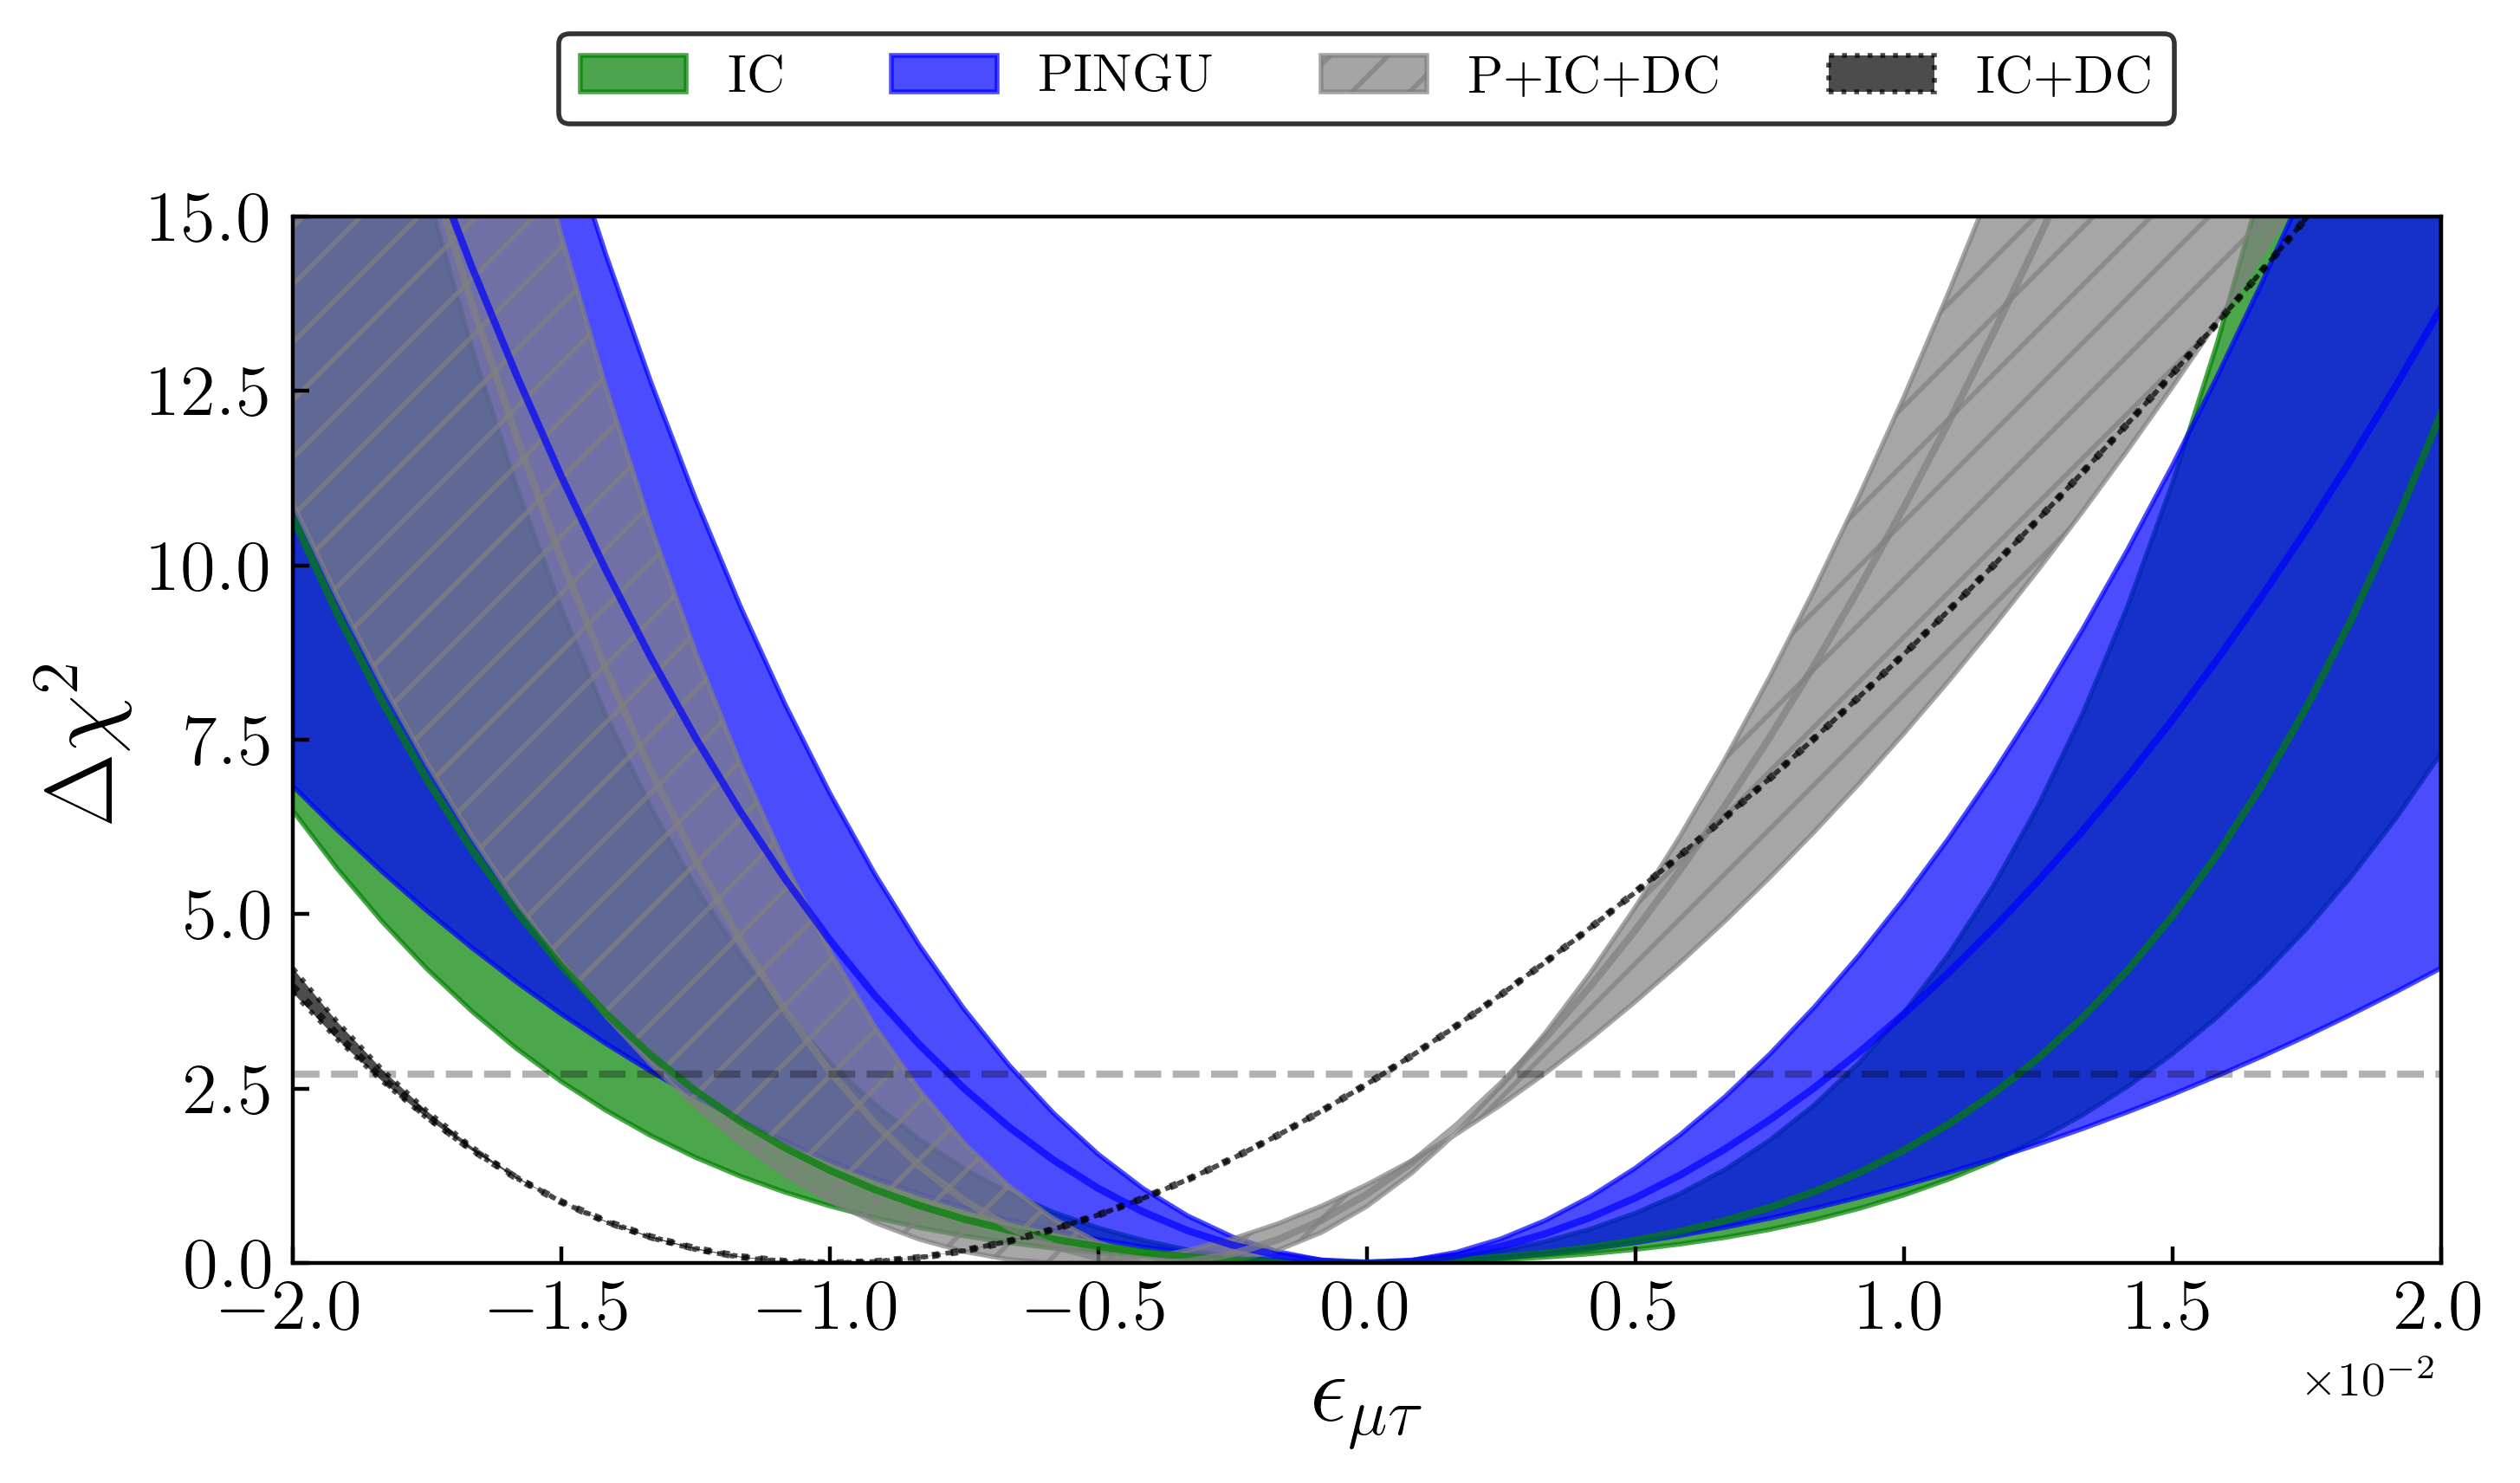

In [156]:
fig,ax = plt.subplots(1,1,figsize=(8,4))
finer_e_range = np.linspace(-2e-2,2e-2,49)

ax.fill_between(finer_e_range, best_cases['I_emt'], worst_cases['I_emt'],label='IC ', alpha=0.7, color='g')
ax.plot(finer_e_range, normal_cases['I_emt'], alpha=0.7, lw=1.5, color='g')
ax.fill_between(finer_e_range, best_cases['P_emt'], worst_cases['P_emt'],label='PINGU', alpha=0.7, color='b')
ax.plot(finer_e_range, normal_cases['P_emt'], alpha=0.7, lw=1.5, color='b')
ax.fill_between(finer_e_range, best_cases['PID_emt'], worst_cases['PID_emt'], label='P+IC+DC', alpha=0.7,color='grey', hatch='//')
ax.plot(finer_e_range, normal_cases['PID_emt'], alpha=0.7, lw=1.5,color='grey')
ax.fill_between(finer_e_range, best_cases['ID_emt'], worst_cases['ID_emt'],label='IC+DC', alpha=0.7, color='k', ls='dotted')
ax.plot(finer_e_range, normal_cases['ID_emt'], alpha=0.7, lw=1.5,color='k', ls='dotted')

ax.axhline(chi2.ppf(0.9,1), alpha=0.3, c='black', ls = '--')

ax.set_ylim(bottom=0, top=15)
ax.set_xlim(left=-2e-2, right=2e-2)
ax.set_xlabel(r'$\epsilon_{\mu\tau}$', fontsize=20)
ax.set_ylabel(r'$\Delta \chi^2$', fontsize=20)
ax.tick_params(labelsize=15)
handles, labels = ax.get_legend_handles_labels()
leg= ax.legend(handles, labels, loc='upper center', ncol=4, bbox_to_anchor=(0.5, 1.2),fontsize=11)
leg.get_frame().set_edgecolor('k')
ax.tick_params(axis='both', direction='in', which='both')
ax.ticklabel_format(axis="x", style="sci", scilimits=(0,0))
plt.subplots_adjust(hspace=0.6)
fig.savefig('article/figures/PID_3D_emt.pdf', bbox_inches="tight")
#from subprocess import call 
#_ = call('pdfcrop article/figures/PID_3D_emt.pdf article/figures/PID_3D_emt.pdf')

hard-coded nsi_ranges
<ipython-input-153-3c5301b71518>:76: UserWarning: This figure was using constrained_layout, but that is incompatible with subplots_adjust and/or tight_layout; disabling constrained_layout.
  plt.subplots_adjust(hspace=0.5)


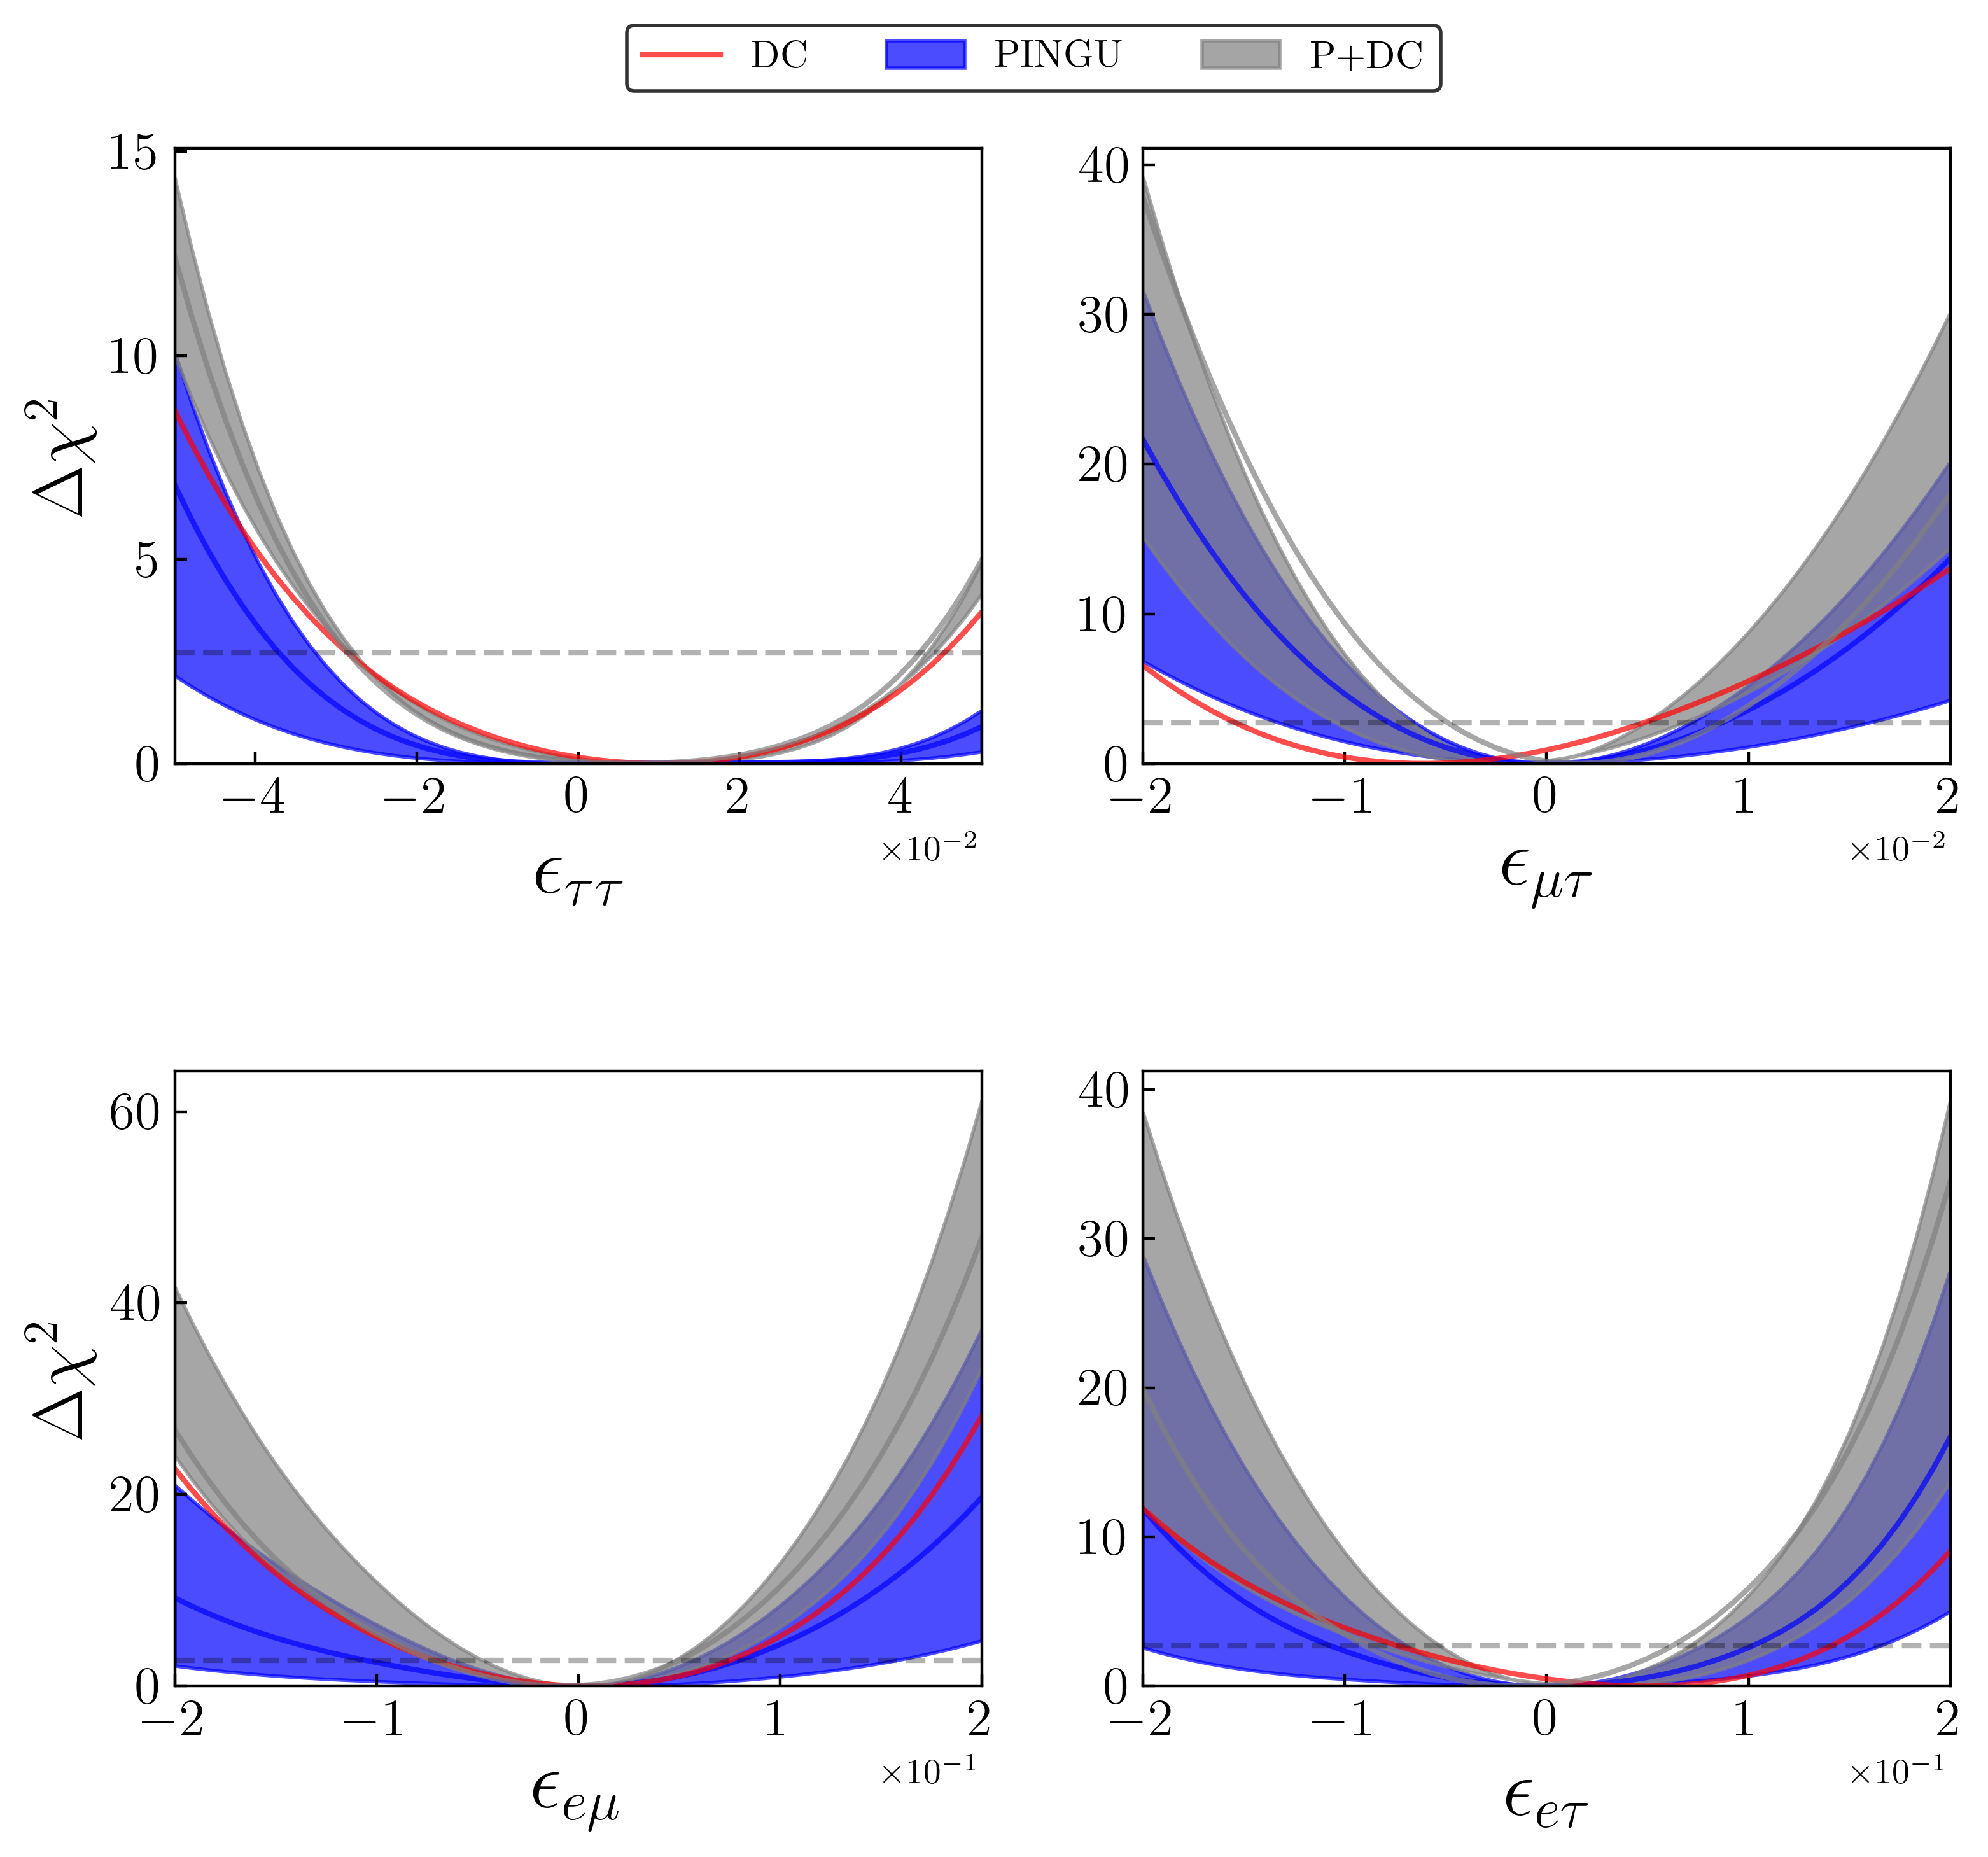

In [153]:
nsi_param_range = [np.linspace(-5e-2,5e-2,9),np.linspace(-2e-2,2e-2,9), np.linspace(-2e-1,2e-1,9), np.linspace(-2e-1,2e-1,9)]

print('hard-coded nsi_ranges')
fig, ax = plt.subplots(2,2,figsize=(9,8), constrained_layout=True)
ax = ax.flatten()
demidov_ett = (-0.055, 0.056)
demidov_emt = (-0.023, 0.016)
demidov_eem = (-0.21, 0.20)
demidov_eet = (-0.19, 0.20)
xlabels = [r'$\epsilon_{\tau\tau}$', r'$\epsilon_{\mu\tau}$', r'$\epsilon_{e\mu}$', r'$\epsilon_{e\tau}$']
demidovs =[demidov_ett, demidov_emt, demidov_eem, demidov_eet]

for i in range(4):
    finer_e_range = np.linspace(nsi_param_range[i].min(),nsi_param_range[i].max(),49)

    ax[i].fill_between(finer_e_range, worst_cases[f'P_{nsi_list[i]}'], best_cases[f'P_{nsi_list[i]}'], label='PINGU', alpha=0.7, color='b')
    ax[i].plot(finer_e_range, normal_cases[f'P_{nsi_list[i]}'], alpha=0.7, color='b', lw=1.5)
    ax[i].plot(finer_e_range, normal_cases[f'D_{nsi_list[i]}'], label='DC', alpha=0.7, color='r', lw=1.5)
    ax[i].fill_between(finer_e_range, worst_cases[f'PD_{nsi_list[i]}'], best_cases[f'PD_{nsi_list[i]}'], label='P+DC', alpha=0.7, color='grey')
    ax[i].plot(finer_e_range, normal_cases[f'PD_{nsi_list[i]}'], alpha=0.7, color='grey')

    ax[i].axhline(chi2.ppf(0.9,1), alpha=0.3, c='black', ls = '--')

    #ax[i].axvline(demidovs[i][0], alpha=0.6,c='black', label=r'Demidov NO')
    #ax[i].axvline(demidovs[i][1], alpha=0.6,c='black')
    ax[i].set_ylim(bottom=0)
    ax[i].set_xlim((nsi_param_range[i].min(), nsi_param_range[i].max()))
    ax[i].set_xlabel(xlabels[i], fontsize=23)
    ax[i].tick_params(labelsize=15,axis='both', direction='in', which='both')
    ax[i].ticklabel_format(axis="x", style="sci", scilimits=(0,0))
    '''
    cl_90_bounds_PINGU_best = splrep(finer_e_range, P_marg_NO_best[i]- chi2.ppf(0.9,1))
    three_sigma_bounds_PINGU_best = splrep(finer_e_range, P_marg_NO_best[i]- chi2.ppf(0.9973,1))
    


    cl_90_bounds_DC= splrep(finer_e_range, D_marg_NO[i]- chi2.ppf(0.9,1))
    three_sigma_bounds_DC = splrep(finer_e_range, D_marg_NO[i]- chi2.ppf(0.9973,1))

    cl_90_bounds_joint_best = splrep(finer_e_range, PD_marg_NO_best[i]- chi2.ppf(0.9,1))
    three_sigma_bounds_joint_best = splrep(finer_e_range, PD_marg_NO_best[i]- chi2.ppf(0.9973,1))

    cl_90_bounds_PINGU_worst = splrep(finer_e_range, P_marg_NO_worst[i]- chi2.ppf(0.9,1))
    three_sigma_bounds_PINGU_worst = splrep(finer_e_range, P_marg_NO_worst[i]- chi2.ppf(0.9973,1))
    


    cl_90_bounds_DC= splrep(finer_e_range, D_marg_NO[i]- chi2.ppf(0.9,1))
    three_sigma_bounds_DC = splrep(finer_e_range, D_marg_NO[i]- chi2.ppf(0.9973,1))

    cl_90_bounds_joint_worst = splrep(finer_e_range, PD_marg_NO_worst[i]- chi2.ppf(0.9,1))
    three_sigma_bounds_joint_worst = splrep(finer_e_range, PD_marg_NO_worst[i]- chi2.ppf(0.9973,1))


    P_90_best.append(np.round(sproot(cl_90_bounds_PINGU_best),3))
    P_3s_best.append(np.round(sproot(three_sigma_bounds_PINGU_best),3))

    D_90.append(np.round(sproot(cl_90_bounds_DC),3))
    D_3s.append(np.round(sproot(three_sigma_bounds_DC),3))

    PD_90_best.append(np.round(sproot(cl_90_bounds_joint_best),3))
    PD_3s_best.append(np.round(sproot(three_sigma_bounds_joint_best),3))

    P_90_worst.append(np.round(sproot(cl_90_bounds_PINGU_worst),3))
    P_3s_worst.append(np.round(sproot(three_sigma_bounds_PINGU_worst),3))


    PD_90_worst.append(np.round(sproot(cl_90_bounds_joint_worst),3))
    PD_3s_worst.append(np.round(sproot(three_sigma_bounds_joint_worst),3))
    '''
ax[0].set_ylabel(r'$\Delta \chi^2$', fontsize=20)
ax[2].set_ylabel(r'$\Delta \chi^2$', fontsize=20)
handles, labels = ax[1].get_legend_handles_labels()
leg= fig.legend(handles, labels, loc='upper center', ncol=3, bbox_to_anchor=(0.5, 0.95),fontsize=11)
leg.get_frame().set_edgecolor('k')
plt.subplots_adjust(hspace=0.5)
plt.savefig('./article/figures/joint_3D_NO.pdf', bbox_inches="tight")
#save(fig, 'joint_3D_NO') #Doesnt work, legend removed
#savethesis(fig, 'joint_3D_NO')#Doesnt work, legend removed

In [18]:
cl_90_bounds_PID_worst = np.round(sproot(splrep(finer_e_range, worst_cases['PID_emt'] - chi2.ppf(0.9,1))),3)
sproot(cl_90_bounds_PID_worst)

array([-0.1314,  0.0329])

In [128]:
cl_90_bounds_PID_worst = splrep(finer_e_range, PID_interpolated_emt_worst- chi2.ppf(0.9,1))
three_sigma_bounds_PID_worst = splrep(finer_e_range, PID_interpolated_emt_worst- chi2.ppf(0.9973,1))
cl_90_bounds_I_worst = splrep(finer_e_range, I_interpolated_emt- chi2.ppf(0.9,1))
three_sigma_bounds_I_worst = splrep(finer_e_range, I_interpolated_emt_worst- chi2.ppf(0.9973,1))
cl_90_bounds_ID_worst = splrep(finer_e_range, ID_interpolated_emt_worst- chi2.ppf(0.9,1))
three_sigma_bounds_ID_worst = splrep(finer_e_range, ID_interpolated_emt_worst- chi2.ppf(0.9973,1))

cl_90_bounds_PID_best = splrep(finer_e_range, PID_interpolated_emt_best- chi2.ppf(0.9,1))
three_sigma_bounds_PID_best = splrep(finer_e_range, PID_interpolated_emt_best- chi2.ppf(0.9973,1))
cl_90_bounds_I_best = splrep(finer_e_range, I_interpolated_emt- chi2.ppf(0.9,1))
three_sigma_bounds_I_best = splrep(finer_e_range, I_interpolated_emt_best- chi2.ppf(0.9973,1))
cl_90_bounds_ID_best = splrep(finer_e_range, ID_interpolated_emt_best- chi2.ppf(0.9,1))
three_sigma_bounds_ID_best = splrep(finer_e_range, ID_interpolated_emt_best- chi2.ppf(0.9973,1))


PID_90_best.append(np.round(sproot(cl_90_bounds_PID_best),3))
I_90_best.append(np.round(sproot(cl_90_bounds_I_best),3))
ID_90_best.append(np.round(sproot(cl_90_bounds_ID_best),3))

PID_3s_best.append(np.round(sproot(three_sigma_bounds_PID_best),3))
I_3s_best.append(np.round(sproot(three_sigma_bounds_I_best),3))
ID_3s_best.append(np.round(sproot(three_sigma_bounds_ID_best),3))

PID_90_worst.append(np.round(sproot(cl_90_bounds_PID_worst),3))
I_90_worst.append(np.round(sproot(cl_90_bounds_I_worst),3))
ID_90_worst.append(np.round(sproot(cl_90_bounds_ID_worst),3))

PID_3s_worst.append(np.round(sproot(three_sigma_bounds_PID_worst),3))
I_3s_worst.append(np.round(sproot(three_sigma_bounds_I_worst),3))
ID_3s_worst.append(np.round(sproot(three_sigma_bounds_ID_worst),3))

In [142]:
index_list = ['$\epsilon_{\tau\tau}$', '$\epsilon_{\mu\tau}$', '$\epsilon_{e\mu}$', '$\epsilon_{e\tau}$']
df_I = pd.DataFrame(columns=['Best 90', 'Best 3s', 'Normal 90', 'Normal 3s', 'Worst 90', 'Worst 3s'],index=index_list, dtype=object)
df_D = pd.DataFrame(columns=['Best 90', 'Best 3s', 'Normal 90', 'Normal 3s', 'Worst 90', 'Worst 3s'],index=index_list, dtype=object)
df_ID = pd.DataFrame(columns=['Best 90', 'Best 3s', 'Normal 90', 'Normal 3s', 'Worst 90', 'Worst 3s'],index=index_list, dtype=object)

df_P = pd.DataFrame(columns=['Best 90', 'Best 3s', 'Normal 90', 'Normal 3s', 'Worst 90', 'Worst 3s'],index=index_list, dtype=object)
df_PD = pd.DataFrame(columns=['Best 90', 'Best 3s', 'Normal 90', 'Normal 3s', 'Worst 90', 'Worst 3s'],index=index_list, dtype=object)
df_PID = pd.DataFrame(columns=['Best 90', 'Best 3s', 'Normal 90', 'Normal 3s', 'Worst 90', 'Worst 3s'],index=index_list, dtype=object)
nsi_param_range = [np.linspace(-5e-2,5e-2,49),np.linspace(-2e-2,2e-2,49), np.linspace(-2e-1,2e-1,49), np.linspace(-2e-1,2e-1,49)]
for i,epsilon in enumerate(nsi_list):
    df_P.loc[index_list[i],f'Best 90'] = np.round(sproot(splrep(nsi_param_range[i], best_cases[f'P_{epsilon}'] - chi2.ppf(0.9,1))),3)
    df_P.loc[index_list[i],f'Best 3s'] = np.round(sproot(splrep(nsi_param_range[i], best_cases[f'P_{epsilon}'] - chi2.ppf(0.9973,1))),3)

    df_D.loc[index_list[i],f'Best 90'] = np.round(sproot(splrep(nsi_param_range[i], normal_cases[f'D_{epsilon}'] - chi2.ppf(0.9,1))),3)
    df_D.loc[index_list[i],f'Best 3s'] = np.round(sproot(splrep(nsi_param_range[i], normal_cases[f'D_{epsilon}'] - chi2.ppf(0.9973,1))),3)

    df_PD.loc[index_list[i],f'Best 90'] = np.round(sproot(splrep(nsi_param_range[i], best_cases[f'PD_{epsilon}'] - chi2.ppf(0.9,1))),3)
    df_PD.loc[index_list[i],f'Best 3s'] = np.round(sproot(splrep(nsi_param_range[i], best_cases[f'PD_{epsilon}'] - chi2.ppf(0.9973,1))),3)

    df_P.loc[index_list[i],f'Normal 90'] = np.round(sproot(splrep(nsi_param_range[i], normal_cases[f'P_{epsilon}'] - chi2.ppf(0.9,1))),3)
    df_P.loc[index_list[i],f'Normal 3s'] = np.round(sproot(splrep(nsi_param_range[i], normal_cases[f'P_{epsilon}'] - chi2.ppf(0.9973,1))),3)

    df_D.loc[index_list[i],f'Normal 90'] = np.round(sproot(splrep(nsi_param_range[i], normal_cases[f'D_{epsilon}'] - chi2.ppf(0.9,1))),3)
    df_D.loc[index_list[i],f'Normal 3s'] = np.round(sproot(splrep(nsi_param_range[i], normal_cases[f'D_{epsilon}'] - chi2.ppf(0.9973,1))),3)

    df_PD.loc[index_list[i],f'Normal 90'] = np.round(sproot(splrep(nsi_param_range[i], normal_cases[f'PD_{epsilon}'] - chi2.ppf(0.9,1))),3)
    df_PD.loc[index_list[i],f'Normal 3s'] = np.round(sproot(splrep(nsi_param_range[i], normal_cases[f'PD_{epsilon}'] - chi2.ppf(0.9973,1))),3)

    df_P.loc[index_list[i],f'Worst 90'] = np.round(sproot(splrep(nsi_param_range[i], worst_cases[f'P_{epsilon}'] - chi2.ppf(0.9,1))),3)
    df_P.loc[index_list[i],f'Worst 3s'] = np.round(sproot(splrep(nsi_param_range[i], worst_cases[f'P_{epsilon}'] - chi2.ppf(0.9973,1))),3)
    
    df_D.loc[index_list[i],f'Worst 90'] = np.round(sproot(splrep(nsi_param_range[i], worst_cases[f'D_{epsilon}'] - chi2.ppf(0.9,1))),3)
    df_D.loc[index_list[i],f'Worst 3s'] = np.round(sproot(splrep(nsi_param_range[i], worst_cases[f'D_{epsilon}'] - chi2.ppf(0.9973,1))),3)

    df_PD.loc[index_list[i],f'Worst 90'] = np.round(sproot(splrep(nsi_param_range[i], worst_cases[f'PD_{epsilon}'] - chi2.ppf(0.9,1))),3)
    df_PD.loc[index_list[i],f'Worst 3s'] = np.round(sproot(splrep(nsi_param_range[i], worst_cases[f'PD_{epsilon}'] - chi2.ppf(0.9973,1))),3)

    if epsilon == 'emt':
        df_I.loc[index_list[i],f'Best 90'] = np.round(sproot(splrep(nsi_param_range[i], best_cases[f'I_{epsilon}'] - chi2.ppf(0.9,1))),3)
        df_I.loc[index_list[i],f'Best 3s'] = np.round(sproot(splrep(nsi_param_range[i], best_cases[f'I_{epsilon}'] - chi2.ppf(0.9973,1))),3)
        df_ID.loc[index_list[i],f'Best 90'] = np.round(sproot(splrep(nsi_param_range[i], best_cases[f'ID_{epsilon}'] - chi2.ppf(0.9,1))),3)
        df_ID.loc[index_list[i],f'Best 3s'] = np.round(sproot(splrep(nsi_param_range[i], best_cases[f'ID_{epsilon}'] - chi2.ppf(0.9973,1))),3)
        df_PID.loc[index_list[i],f'Best 90'] = np.round(sproot(splrep(nsi_param_range[i], best_cases[f'PID_{epsilon}'] - chi2.ppf(0.9,1))),3)
        df_PID.loc[index_list[i],f'Best 3s'] = np.round(sproot(splrep(nsi_param_range[i], best_cases[f'PID_{epsilon}'] - chi2.ppf(0.9973,1))),3)

        df_I.loc[index_list[i],f'Normal 90'] = np.round(sproot(splrep(nsi_param_range[i], normal_cases[f'I_{epsilon}'] - chi2.ppf(0.9,1))),3)
        df_I.loc[index_list[i],f'Normal 3s'] = np.round(sproot(splrep(nsi_param_range[i], normal_cases[f'I_{epsilon}'] - chi2.ppf(0.9973,1))),3)
        df_ID.loc[index_list[i],f'Normal 90'] = np.round(sproot(splrep(nsi_param_range[i], normal_cases[f'ID_{epsilon}'] - chi2.ppf(0.9,1))),3)
        df_ID.loc[index_list[i],f'Normal 3s'] = np.round(sproot(splrep(nsi_param_range[i], normal_cases[f'ID_{epsilon}'] - chi2.ppf(0.9973,1))),3)
        df_PID.loc[index_list[i],f'Normal 90'] =np.round(sproot(splrep(nsi_param_range[i], normal_cases[f'PID_{epsilon}'] - chi2.ppf(0.9,1))),3)
        df_PID.loc[index_list[i],f'Normal 3s'] = np.round(sproot(splrep(nsi_param_range[i], normal_cases[f'PID_{epsilon}'] - chi2.ppf(0.9973,1))),3)
        
        df_I.loc[index_list[i],f'Worst 90'] = np.round(sproot(splrep(nsi_param_range[i], worst_cases[f'I_{epsilon}'] - chi2.ppf(0.9,1))),3)
        df_I.loc[index_list[i],f'Worst 3s'] = np.round(sproot(splrep(nsi_param_range[i], worst_cases[f'I_{epsilon}'] - chi2.ppf(0.9973,1))),3)
        df_ID.loc[index_list[i],f'Worst 90'] = np.round(sproot(splrep(nsi_param_range[i], worst_cases[f'ID_{epsilon}'] - chi2.ppf(0.9,1))),3)
        df_ID.loc[index_list[i],f'Worst 3s'] = np.round(sproot(splrep(nsi_param_range[i], worst_cases[f'ID_{epsilon}'] - chi2.ppf(0.9973,1))),3)
        df_PID.loc[index_list[i],f'Worst 90'] = np.round(sproot(splrep(nsi_param_range[i], worst_cases[f'PID_{epsilon}'] - chi2.ppf(0.9,1))),3)
        df_PID.loc[index_list[i],f'Worst 3s'] = np.round(sproot(splrep(nsi_param_range[i], worst_cases[f'PID_{epsilon}'] - chi2.ppf(0.9973,1))),3)
   

In [143]:
df_I

,Best 90,Best 3s,Normal 90,Normal 3s,Worst 90,Worst 3s
$\epsilon_{\tau\tau}$,NaN,NaN,NaN,NaN,NaN,NaN
$\epsilon_{\mu\tau}$,"[-0.01, 0.009]","[-0.015, 0.014]","[-0.013, 0.012]","[-0.019, 0.018]","[-0.015, 0.014]",[]
$\epsilon_{e\mu}$,NaN,NaN,NaN,NaN,NaN,NaN
$\epsilon_{e\tau}$,NaN,NaN,NaN,NaN,NaN,NaN


In [150]:
ID_table = pd.concat([df_I, df_D,df_ID]).dropna()

PID_table = pd.concat([df_P, df_PD,df_PID]).dropna()

In [149]:
ID_table.dropna()

,Best 90,Best 3s,Normal 90,Normal 3s,Worst 90,Worst 3s
$\epsilon_{\mu\tau}$,"[-0.01, 0.009]","[-0.015, 0.014]","[-0.013, 0.012]","[-0.019, 0.018]","[-0.015, 0.014]",[]
$\epsilon_{\tau\tau}$,"[-0.029, 0.045]",[],"[-0.029, 0.045]",[],"[-0.029, 0.045]",[]
$\epsilon_{\mu\tau}$,"[-0.015, 0.005]",[0.015],"[-0.015, 0.005]",[0.015],"[-0.015, 0.005]",[0.015]
$\epsilon_{e\mu}$,"[-0.071, 0.075]","[-0.132, 0.127]","[-0.071, 0.075]","[-0.132, 0.127]","[-0.071, 0.075]","[-0.132, 0.127]"
$\epsilon_{e\tau}$,"[-0.074, 0.141]","[-0.174, 0.2]","[-0.074, 0.141]","[-0.174, 0.2]","[-0.074, 0.141]","[-0.174, 0.2]"
$\epsilon_{\mu\tau}$,"[-0.018, 0.0]",[0.01],"[-0.018, 0.0]",[0.01],"[-0.018, 0.0]",[0.01]


In [139]:
df_P

,Best 90,Best 3s,Normal 90,Normal 3s,Worst 90,Worst 3s
ett,[-0.033],[-0.048],[-0.037],[],[],[]
emt,"[-0.007, 0.007]","[-0.011, 0.013]","[-0.008, 0.009]","[-0.014, 0.016]","[-0.013, 0.016]",[]
eem,"[-0.062, 0.057]","[-0.122, 0.103]","[-0.106, 0.08]","[-0.198, 0.141]",[0.158],[]
eet,"[-0.069, 0.077]","[-0.121, 0.133]","[-0.107, 0.102]","[-0.181, 0.163]",[0.165],[]


In [152]:
print(PID_table.to_latex(header=['Best 90\% CL','Best $3\sigma$','Normal 90\% CL','Normal $3\sigma$','Worst 90\% CL','Worst $3\sigma$'], index_names=True, column_format='lcccc',escape=False))

\begin{tabular}{lcccc}
\toprule
{} &     Best 90\% CL &   Best $3\sigma$ &   Normal 90\% CL & Normal $3\sigma$ &    Worst 90\% CL &  Worst $3\sigma$ \\
\midrule
$\epsilon_{\tau\tau}$ &         [-0.033] &         [-0.048] &         [-0.037] &               [] &               [] &               [] \\
$\epsilon_{\mu\tau}$  &  [-0.007, 0.007] &  [-0.011, 0.013] &  [-0.008, 0.009] &  [-0.014, 0.016] &  [-0.013, 0.016] &               [] \\
$\epsilon_{e\mu}$     &  [-0.062, 0.057] &  [-0.122, 0.103] &   [-0.106, 0.08] &  [-0.198, 0.141] &          [0.158] &               [] \\
$\epsilon_{e\tau}$    &  [-0.069, 0.077] &  [-0.121, 0.133] &  [-0.107, 0.102] &  [-0.181, 0.163] &          [0.165] &               [] \\
$\epsilon_{\tau\tau}$ &  [-0.028, 0.043] &         [-0.043] &  [-0.029, 0.042] &         [-0.045] &  [-0.028, 0.044] &         [-0.048] \\
$\epsilon_{\mu\tau}$  &  [-0.007, 0.005] &   [-0.011, 0.01] &  [-0.005, 0.009] &   [-0.01, 0.015] &   [-0.01, 0.007] &  [-0.016, 0.015] \\
$\eps

In [169]:
PID_table

,Best 90,Best 3s,Worst 90,Worst 3s
\epsilon{\tau\tau},[-0.033],[-0.048],[-0.037],[]
$\epsilon{\mu\tau}$,"[-0.007, 0.007]","[-0.011, 0.013]","[-0.008, 0.009]","[-0.014, 0.016]"
$\epsilon{e\mu}$,"[-0.062, 0.057]","[-0.122, 0.103]","[-0.106, 0.08]","[-0.198, 0.141]"
$\epsilon{e\tau}$,"[-0.069, 0.077]","[-0.121, 0.133]","[-0.107, 0.102]","[-0.181, 0.163]"
$\epsilon{\tau\tau}$,"[-0.028, 0.043]",[-0.043],"[-0.029, 0.042]",[-0.045]
$\epsilon{\mu\tau}$,"[-0.007, 0.005]","[-0.011, 0.01]","[-0.005, 0.009]","[-0.01, 0.015]"
$\epsilon{e\mu}$,"[-0.048, 0.048]","[-0.09, 0.085]","[-0.072, 0.05]","[-0.126, 0.093]"
$\epsilon{e\tau}$,"[-0.053, 0.071]","[-0.1, 0.117]","[-0.09, 0.062]","[-0.149, 0.117]"
$\epsilon{\mu\tau}$,"[-0.1, 0.027]","[-0.144, 0.087]","[-0.1, 0.027]","[-0.144, 0.087]"


In [171]:
PID_table.index = ['$\ett$',
                   '$\emt$',
                   '$\eem$',
                   '$\eet$',
                   '$\ett$',
                   '$\emt$',
                   '$\eem$',
                   '$\eet$',
                   '$\emt$']

In [128]:
from scipy.interpolate import splev
tk = splrep(np.linspace(nsi_param_range[0].min(),nsi_param_range[0].max(),49), PD_marg_NO[0]- chi2.ppf(0.9973,1))
def f(x,tk):
    return splev(x,tk)

from scipy.optimize import root_scalar

root = root_scalar(f, args=(tk,), x0=0.07, x1 = 0.1).root
f(root,tk), root

(array(1.4211e-13), 0.05875209011067248)